In [1]:
import tensorflow as tf

In [2]:
tf.test.is_built_with_cuda()

True

In [3]:
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.data import Dataset
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dropout, Concatenate, BatchNormalization, Activation, Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [5]:
img_width, img_height = 256, 256
img_size = img_width, img_height
input_channels = 3
output_channels = 1
input_shape = (img_size, input_channels)
output_shape = (img_size, output_channels)
seed = 13
batch_size = 16

train_dir = "train/image/"
train_mask_dir = "train/label/"
val_dir = "val/image/"
val_mask_dir = "val/label/"
test_dir = "test/image/"
test_mask_dir = "test/label/"

In [6]:
def clean_image_dir(dir_name):
  files = os.listdir(dir_name)
  for f in files:
    file_name = os.path.splitext(f)[0]
    extension = os.path.splitext(f)[1]
    if extension == ".tif":
      img = cv2.imread(dir_name+f)
      cv2.imwrite(dir_name+file_name+".jpg", img)
      os.remove(dir_name+f)

def clean_image_mask_dir(dir_name):
  files = os.listdir(dir_name)
  for f in files:
    file_name = os.path.splitext(f)[0]
    extension = os.path.splitext(f)[1]
    if extension == ".tif":
      img = cv2.imread(dir_name+f)
      img = img[:,:,0]+1
      cv2.imwrite(dir_name+file_name+".png", img)
      os.remove(dir_name+f)

In [7]:
clean_image_dir(train_dir)
clean_image_mask_dir(train_mask_dir)

clean_image_dir(val_dir)
clean_image_mask_dir(val_mask_dir)

clean_image_dir(test_dir)
clean_image_mask_dir(test_mask_dir)

Found 4736 files belonging to 1 classes.
Found 4736 files belonging to 1 classes.
Found 1036 files belonging to 1 classes.
Found 1036 files belonging to 1 classes.
Found 2416 files belonging to 1 classes.
Found 2416 files belonging to 1 classes.


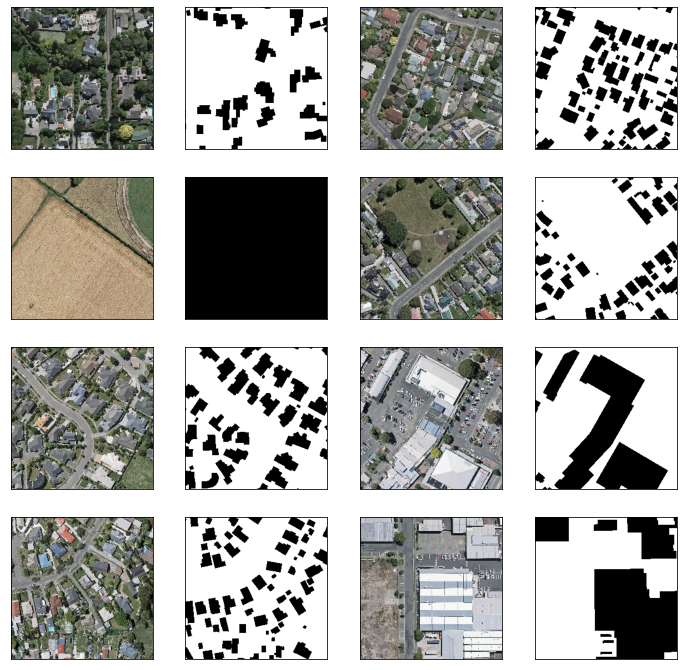

In [8]:
def generate_dataset_from_directory(directory, color_mode="rgb", interpolation="nearest", validation_split=None, subset=None):
  # Generamos el objeto Dataset a partir de un directorio
  ds = image_dataset_from_directory(
      directory,
      labels=None,
      label_mode=None,
      batch_size=batch_size,
      image_size=(img_width, img_height),
      seed=seed,
      interpolation=interpolation,
      color_mode=color_mode,
      validation_split=validation_split,
      subset=subset)
  return ds.prefetch(buffer_size=batch_size)

input_ds_train = generate_dataset_from_directory(train_dir)
mask_ds_train = generate_dataset_from_directory(train_mask_dir, color_mode="grayscale")

input_ds_val = generate_dataset_from_directory(val_dir)
mask_ds_val = generate_dataset_from_directory(val_mask_dir, color_mode="grayscale")

input_ds_test = generate_dataset_from_directory(test_dir)
mask_ds_test = generate_dataset_from_directory(test_mask_dir, color_mode="grayscale")

# En este tipo de problemas tenemos que 'casar' manualmente los datos asignando una máscara a cada una de las imágenes de cada dataset
train_dataset = Dataset.zip((input_ds_train, mask_ds_train))
val_dataset = Dataset.zip((input_ds_val, mask_ds_val))
test_dataset = Dataset.zip((input_ds_test, mask_ds_test))

sample_size = 8
cols = 4
rows = sample_size * 2 // cols
plt.figure(figsize=(cols * 3, rows * 3))

for x_batch, y_batch in train_dataset.take(1):
  for i in range(sample_size):
    plt.subplot(rows, cols, i * 2 + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_batch[i])
    plt.subplot(rows, cols, i * 2 + 2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(y_batch[i].numpy()[:,:,0], cmap="gray")

In [17]:
from tensorflow.keras import layers

def get_model(img_size,num_classes):
    inputs = tf.keras.Input(shape = img_size + (3,))

    ### [First half of the network: downsampling inputs] ###
    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = tf.keras.Model(inputs, outputs)
    return model

# Free up RAM in case the model definition cells were run multiple times
tf.keras.backend.clear_session()

# Build model
model = get_model(img_size, 2)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [18]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
             ModelCheckpoint(
                 'checkpoint/unet-{val_loss:03f}-({epoch:02d}).h5',
                 monitor='val_loss',
                 save_best_only=True),
             EarlyStopping(monitor="val_loss", patience=10)
]

history = model.fit(
    train_dataset,
    epochs=100,
    batch_size=batch_size,
    validation_data=val_dataset,
    callbacks=callbacks
    )

Epoch 1/100
296/296 [==============================] - 97s 308ms/step - loss: 0.4025 - val_loss: 0.3234
Epoch 2/100
296/296 [==============================] - 90s 304ms/step - loss: 0.1795 - val_loss: 0.1642
Epoch 3/100
296/296 [==============================] - 93s 314ms/step - loss: 0.1497 - val_loss: 0.0898
Epoch 4/100
296/296 [==============================] - 90s 304ms/step - loss: 0.1355 - val_loss: 0.1111
Epoch 5/100
296/296 [==============================] - 88s 297ms/step - loss: 0.1257 - val_loss: 0.0933
Epoch 6/100
296/296 [==============================] - 94s 317ms/step - loss: 0.1183 - val_loss: 0.1270
Epoch 7/100
296/296 [==============================] - 93s 312ms/step - loss: 0.1125 - val_loss: 0.0673
Epoch 8/100
296/296 [==============================] - 91s 308ms/step - loss: 0.1076 - val_loss: 0.0765
Epoch 9/100
296/296 [==============================] - 90s 304ms/step - loss: 0.1023 - val_loss: 0.0673
Epoch 10/100
296/296 [==============================] - 91s 306m

'\ncallbacks = [\n    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)\n]\n# Train the model, doing validation at the end of each epoch.\nepochs = 15\nmodel.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)\n'

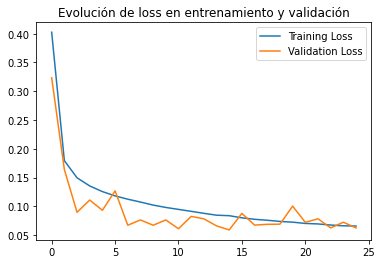

In [19]:
def show_training_graph(data):
  loss = data.history['loss']
  val_loss = data.history['val_loss']

  epochs = range(len(loss))

  plt.plot(epochs, loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.title('Evolución de loss en entrenamiento y validación')
  plt.legend(loc='upper right')

  plt.show()

show_training_graph(history)

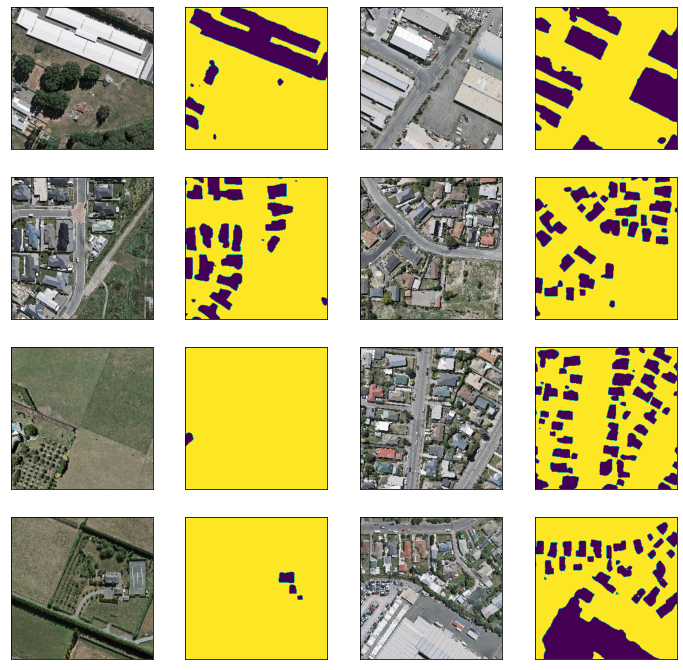

In [20]:
sample_size = 8
cols = 4
rows = sample_size * 2 // cols

plt.figure(figsize=(cols * 3, rows * 3))

for x_batch, y_batch in test_dataset.take(1):
  for i in range(sample_size):
    plt.subplot(rows, cols, i * 2 + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_batch[i])
    plt.subplot(rows, cols, i * 2 + 2)
    plt.xticks([])
    plt.yticks([])
    prediction = model.predict(np.expand_dims(x_batch[i], 0))[0]
    prediction = np.argmax(prediction, axis=-1)
    plt.imshow(prediction)

In [23]:
model.save("ModeloUnet/modelo_tfg_2.h5")

In [22]:
model = load_model("modelo_tfg_2.h5")